In [39]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as F
from  pyspark.sql.functions import col
# data_filepath = "../data/cleaned_steam_reviews/game_id={70,240,420,620}"
data_filepath = "../data/cleaned_steam_reviews"

In [40]:
#spark = SparkSession.builder.appName('games').getOrCreate()
spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

steam_reviews = spark.read.parquet(data_filepath)

# steam_reviews.printSchema()

In [41]:
playerTypeData = steam_reviews.select("app_id", "app_name", "author_steamid",
                                      "author_num_games_owned", "author_num_reviews", "author_playtime_forever",
                                      "author_playtime_last_two_weeks", "author_playtime_at_review", "author_last_played") \
                              .where(col("author_steamid").isNotNull() \
                                        & col("author_num_games_owned").isNotNull() \
                                        & (col("author_num_reviews").isNotNull()) \
                                        & (col("author_playtime_forever").isNotNull()) \
                                        & (col("author_playtime_last_two_weeks").isNotNull()) \
                                        & (col("author_playtime_at_review").isNotNull()) \
                                        & (col("author_last_played").isNotNull())  )

In [42]:
playerTypeData.select([functions.count(functions.when(functions.isnull(c), c)).alias(c) for c in playerTypeData.columns]).show()
playerTypeData.select([functions.count(functions.when(functions.isnan(c), c)).alias(c) for c in playerTypeData.columns]).show()

+------+--------+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|app_id|app_name|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+------+--------+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|     0|       0|             0|                     0|                 0|                      0|                             0|                        0|                 0|
+------+--------+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+



+------+--------+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|app_id|app_name|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+------+--------+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|     0|       0|             0|                     0|                 0|                      0|                             0|                        0|                 0|
+------+--------+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+



In [15]:
playerTypeData.show(10)

+------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|app_id|            app_name|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|   240|Counter-Strike: S...|76561199040851490|                    26|                22|                  117.0|                          17.0|                    117.0|      1.61019264E9|
|   240|Counter-Strike: S...|76561198021598681|                   432|                14|                20170.0|                           0.0|                  10506.0|      1.54231987E9|
|   240|Counter-Strike: S...|76561198313535079|   

In [43]:
gameName = playerTypeData.select("app_id", "app_name").distinct()

In [44]:
playerType = playerTypeData.groupBy(col("app_id")) \
                            .agg( \
                              F.count("author_steamid").alias("review_count"), \
                              F.avg("author_num_games_owned").alias("avg_num_games_owned"), \
                              F.avg("author_num_reviews").alias("avg_num_reviews"), \
                              F.avg("author_playtime_forever").alias("avg_playtime_forever"), \
                              F.avg("author_playtime_last_two_weeks").alias("avg_playtime_last_two_weeks"), \
                              F.avg("author_playtime_at_review").alias("avg_playtime_at_review"), \
                              F.avg("author_last_played").alias("avg_last_played") \
                            )

playerType = gameName.join(playerType, "app_id").orderBy(col("app_id").cast(types.IntegerType()))

In [45]:
playerType.show()

+------+--------------------+------------+-------------------+------------------+--------------------+---------------------------+----------------------+--------------------+
|app_id|            app_name|review_count|avg_num_games_owned|   avg_num_reviews|avg_playtime_forever|avg_playtime_last_two_weeks|avg_playtime_at_review|     avg_last_played|
+------+--------------------+------------+-------------------+------------------+--------------------+---------------------------+----------------------+--------------------+
|    70|           Half-Life|       44611| 141.27672547129632|18.642711438882788|  2603.1238259622064|         30.511533029970188|    1394.7682634327857|1.5558420368041964E9|
|   240|Counter-Strike: S...|       99368| 101.36122292891072|11.720584091458015|  29419.339928347155|          85.13779083809678|    20401.543917558974| 1.544887758720876E9|
|   420|Half-Life 2: Epis...|       17820| 190.68894500561169|29.941021324354658|   993.9797418630752|         11.93024691358

In [ ]:
playerType.toPandas().corr()

/var/folders/bn/n488fsxn7ndc1kw3hf1k47000000gn/T/ipykernel_15995/327886810.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  playerType.toPandas().corr()


,review_count,avg_num_games_owned,avg_num_reviews,avg_playtime_forever,avg_playtime_last_two_weeks,avg_playtime_at_review,avg_last_played
review_count,1.000000,-0.331225,-0.302816,0.383757,0.233205,0.397760,0.159008
avg_num_games_owned,-0.331225,1.000000,0.826036,-0.306484,-0.357249,-0.290290,-0.543356
avg_num_reviews,-0.302816,0.826036,1.000000,-0.349989,-0.369261,-0.337647,-0.574040
avg_playtime_forever,0.383757,-0.306484,-0.349989,1.000000,0.728988,0.994507,0.232679
avg_playtime_last_two_weeks,0.233205,-0.357249,-0.369261,0.728988,1.000000,0.703573,0.395946
avg_playtime_at_review,0.397760,-0.290290,-0.337647,0.994507,0.703573,1.000000,0.213022
avg_last_played,0.159008,-0.543356,-0.574040,0.232679,0.395946,0.213022,1.000000


23/11/02 23:22:44 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 3525373 ms exceeds timeout 120000 ms
23/11/02 23:22:44 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/02 23:22:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.

In [53]:
games_owned_vs_playtime_forever = playerType.select("app_name", "avg_num_games_owned", "avg_playtime_forever") \
                                            .where(col("avg_playtime_forever") < 10000)

<AxesSubplot:xlabel='avg_playtime_forever', ylabel='avg_num_games_owned'>

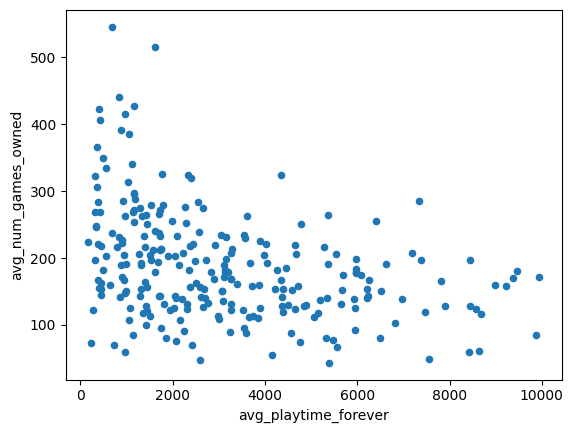

In [49]:
games_owned_vs_playtime_forever.toPandas().plot.scatter(x='avg_playtime_forever', y='avg_num_games_owned') 

In [54]:
games_owned_vs_playtime_forever.toPandas().corr()

/var/folders/bn/n488fsxn7ndc1kw3hf1k47000000gn/T/ipykernel_15995/4281973665.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  games_owned_vs_playtime_forever.toPandas().corr()


,avg_num_games_owned,avg_playtime_forever
avg_num_games_owned,1.00000,-0.37387
avg_playtime_forever,-0.37387,1.00000


<AxesSubplot:xlabel='avg_playtime_forever', ylabel='avg_num_games_owned'>

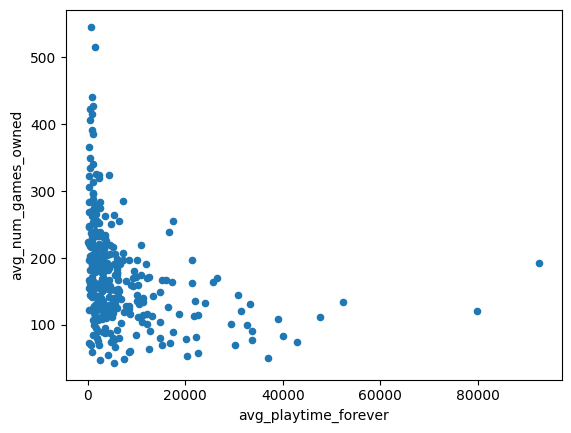

In [51]:
games_owned_vs_playtime_forever.toPandas().plot.scatter(x='avg_playtime_forever', y='avg_num_games_owned') 

In [52]:
games_owned_vs_playtime_forever.toPandas().corr()

/var/folders/bn/n488fsxn7ndc1kw3hf1k47000000gn/T/ipykernel_15995/4281973665.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  games_owned_vs_playtime_forever.toPandas().corr()


,avg_num_games_owned,avg_playtime_forever
avg_num_games_owned,1.000000,-0.306484
avg_playtime_forever,-0.306484,1.000000
